In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from tqdm import tqdm_notebook
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import time
import string # библиотека для работы со строками
import re
import nltk   # Natural Language Toolkit
import pymorphy2 # Морфологический анализатор
import gensim.corpora as corpora
import gensim
from pprint import pprint
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
%matplotlib inline
warnings.filterwarnings("ignore") 

In [2]:
with open('comments_all.json', encoding = 'utf-8') as json_file:
    data = json.load(json_file)

In [3]:
num = 300 

print("movie: ",          data[num]["name_movie"], "\n")
print("comment: \n",      data[num]["text_comment"], "\n")
print("date: ",           data[num]["date_comment"], "\n")
print("type: ",           data[num]["type_comment"], "\n")

movie:  Академия смерти 

comment: 
 Это очень хороший военно-исторический фильм об атмосфере, царящей в закрытом специализированном учебном учреждении Третьего Рейха-учреждении, готовящем будущую элиту общества Великой Германии. Создателям фильма удалось полностью передать эту атмосферу. Будто ты сам очевидец тех событий-и на улице, и в торжественном актовом зале, и на учениях.

Интересный уже сам по себе-ведь Третий Рейх был одним из самых ярких и сильных государств мира! 

Интересна линия отношений между подростками в этом фильме.

Фридрих Ваймер - талантливый боксер из рабочего квартала, мечтающий о лучшей судьбе, мужественный и сильный, упрямый, амбициозный; поступил в элитную школу Рейха против воли отца-рабочего, по собственному желанию, потому что 'такого шанса больше не будет...' 

Альбрехт Штайн - тонкий, хрупкий, романтичный, грустный и мечтательный юноша-эстет, индивидуалист, очень чувствительный; поступил в академию против своей воли, по воле своего отца-гауляйтера, так ка

In [4]:
def custom_preprocessor(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(' +', ' ', text)
    
    return text

In [5]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AlexandrGnusarev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
dates = [str(x) for x in np.arange(0, 2022)]
def process_data(data):
    texts = []
    targets = []
    
    # поочередно проходим по всем новостям в списке
    for item in tqdm_notebook(data):
               
#         text_lower = item['text_comment'].lower() # приводим все слова к нижнему регистру
#         text_lower = ''.join(c for c in text_lower if c not in delSymbols)
        text_lower = custom_preprocessor(item['text_comment'])
        tokens     = word_tokenizer.tokenize(text_lower) #разбиваем екст на слова
        
        # удаляем пунктуацию и стоп-слова
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in dates)]
        
        texts.append(tokens) # добавляем в предобработанный список
    
    return texts

In [7]:
word_tokenizer = nltk.WordPunctTokenizer()
y = [item['type_comment'] for item in data]
texts = process_data(data)

  0%|          | 0/264759 [00:00<?, ?it/s]

In [8]:
i = 300
print("Label: ", y[i])
print("Tokens: ", texts[i][:20])

Label:  good
Tokens:  ['это', 'очень', 'хороший', 'военно', 'исторический', 'фильм', 'атмосфере', 'царящей', 'закрытом', 'специализированном', 'учебном', 'учреждении', 'третьего', 'рейха', 'учреждении', 'готовящем', 'будущую', 'элиту', 'общества', 'великой']


In [9]:
morph = pymorphy2.MorphAnalyzer()

In [10]:
# применяем лемматизацию ко всем текстам
for i in tqdm_notebook(range(len(texts))):           # tqdm_notebook создает шкалу прогресса :)
    text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]] # применяем лемматизацию для каждого слова в тексте
    texts[i] = ' '.join(text_lemmatized)                # объединяем все слова в одну строку через пробел

  0%|          | 0/264759 [00:00<?, ?it/s]

In [11]:
# посмотрим на пример
i = 300
print("Label: ",   y[i])
print("Text: \n",  texts[i])

Label:  good
Text: 
 это очень хороший военный исторический фильм атмосфера царить закрытый специализировать учебный учреждение третий рейх учреждение готовить будущий элита общество великий германия создатель фильм удаться полностью передать атмосфера очевидец тот событие улица торжественный актовый зал учение интересный третий рейх один самый яркий сильный государство мир интересный линия отношение подросток фильм фридрих ваймер талантливый боксёр рабочий квартал мечтать хороший судьба мужественный сильный упрямый амбициозный поступить элитный школа рейх против воля отец рабочий собственный желание такой шанс альбрехт штайна тонкий хрупкий романтичный грустный мечтательный юноша эстет индивидуалист очень чувствительный поступить академия против свой воля воля свой отец гауляйтер это давать определённый привилегия противоположность сходиться такой разный человек вырасти совершенно разный условие разный взгляд воспитание тянуть друг друг простой сильный хрупкий утончить фридрих альбрех

In [12]:
texts1 = []

for x in texts:
    tokens     = word_tokenizer.tokenize(x)
    texts1.append(tokens)

In [14]:
%%time
from gensim.models.ldamulticore import LdaMulticore
id2word = corpora.Dictionary(texts1)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts1]

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True,
                                               workers=8)

pprint(lda_model.print_topics())

[(0,
  '0.012*"который" + 0.011*"человек" + 0.010*"это" + 0.010*"свой" + '
  '0.008*"жизнь" + 0.005*"фильм" + 0.005*"герой" + 0.004*"мир" + 0.004*"сам" + '
  '0.004*"такой"'),
 (1,
  '0.014*"фильм" + 0.012*"который" + 0.007*"свой" + 0.006*"это" + '
  '0.006*"картина" + 0.006*"герой" + 0.006*"персонаж" + 0.005*"первый" + '
  '0.005*"часть" + 0.004*"год"'),
 (2,
  '0.042*"фильм" + 0.022*"это" + 0.009*"который" + 0.008*"такой" + '
  '0.008*"просто" + 0.007*"очень" + 0.006*"смотреть" + 0.006*"сюжет" + '
  '0.005*"сказать" + 0.005*"всё"'),
 (3,
  '0.036*"фильм" + 0.016*"это" + 0.013*"который" + 0.011*"очень" + '
  '0.009*"свой" + 0.007*"роль" + 0.007*"актёр" + 0.006*"хороший" + '
  '0.006*"просто" + 0.006*"такой"')]
Wall time: 4h 31min 52s


In [15]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts1)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.7718   
1            1             1.0              0.4722   
2            2             2.0              0.3793   
3            3             3.0              0.6201   
4            4             0.0              0.5427   
5            5             3.0              0.5842   
6            6             2.0              0.6238   
7            7             2.0              0.8488   
8            8             1.0              0.4625   
9            9             2.0              0.5017   

                                            Keywords  \
0  который, человек, это, свой, жизнь, фильм, гер...   
1  фильм, который, свой, это, картина, герой, пер...   
2  фильм, это, который, такой, просто, очень, смо...   
3  фильм, это, который, очень, свой, роль, актёр,...   
4  который, человек, это, свой, жизнь, фильм, гер...   
5  фильм, это, который, очень, свой, роль, актёр,...   
6  фильм, это, который, такой, просто, очень, смо...   
7  фильм, это, который, такой, просто, очень, смо...   
8  фильм, который, свой, это, картина, герой, пер...   
9  фильм, это, который, такой, просто, очень, смо...   

                                                Text  
0  [правосудие, искать, виновный, вместо, искать,...  
1  [вспомнить, всё, прощать, честно, говорить, эт...  
2  [начитаться, отзыв, загореться, посмотреть, фи...  
3  [фильм, безусловно, провалиться, это, предречь...  
4  [любить, история, любить, чёрный, юмор, элемен...  
5  [честно, судить, фильм, сам, признаться, воспр...  
6  [собственно, кинотеатр, зал, выйти, отличный, ...  
7  [смело, заявлять, просмотр, это, кино, недораб...  
8  [читать, одноимённый, книга, точнее, серия, кн...  
9  [мелькать, первый, мысль, просмотр, данный, ки...

можно посмотреть к какой теме относится каждый документ

In [16]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9985   
1        1.0              0.9974   
2        2.0              0.9967   
3        3.0              0.9977   

                                                                   Keywords  \
0         который, человек, это, свой, жизнь, фильм, герой, мир, сам, такой   
1   фильм, который, свой, это, картина, герой, персонаж, первый, часть, год   
2  фильм, это, который, такой, просто, очень, смотреть, сюжет, сказать, всё   
3     фильм, это, который, очень, свой, роль, актёр, хороший, просто, такой   

                                                                                   Representative Text  
0  [откуда, езмить, пойти, народ, русский, деревня, земля, родимый, хлебосольный, давать, кров, про...  
1  [создатель, ремейк, продолжение, тот, иной, картина, давно, успеть, превратиться, центральный, п...  
2  [недавно, мир, узнать, сам, пугать, фильм, говорить, сам, продюссер, пропустить, это, мимо, ухо,...  
3  [бывать, совершенно, разный, история, любовь, мочь, весёлый, романтичный, мочь, грустный, мочь, ...

также можно получить список слов наиболее полно отражающих каждую тему. видно что во всех темах встречается слово "фильм" - это понятно. у нас рецензии на фильм. при этом первая тема описывает героя и мир в котором он живет видимо. вторая тема больше настроена на персонажа, третья на сюжет, а четвертая больше описавает фильм со стороны игры актеров.

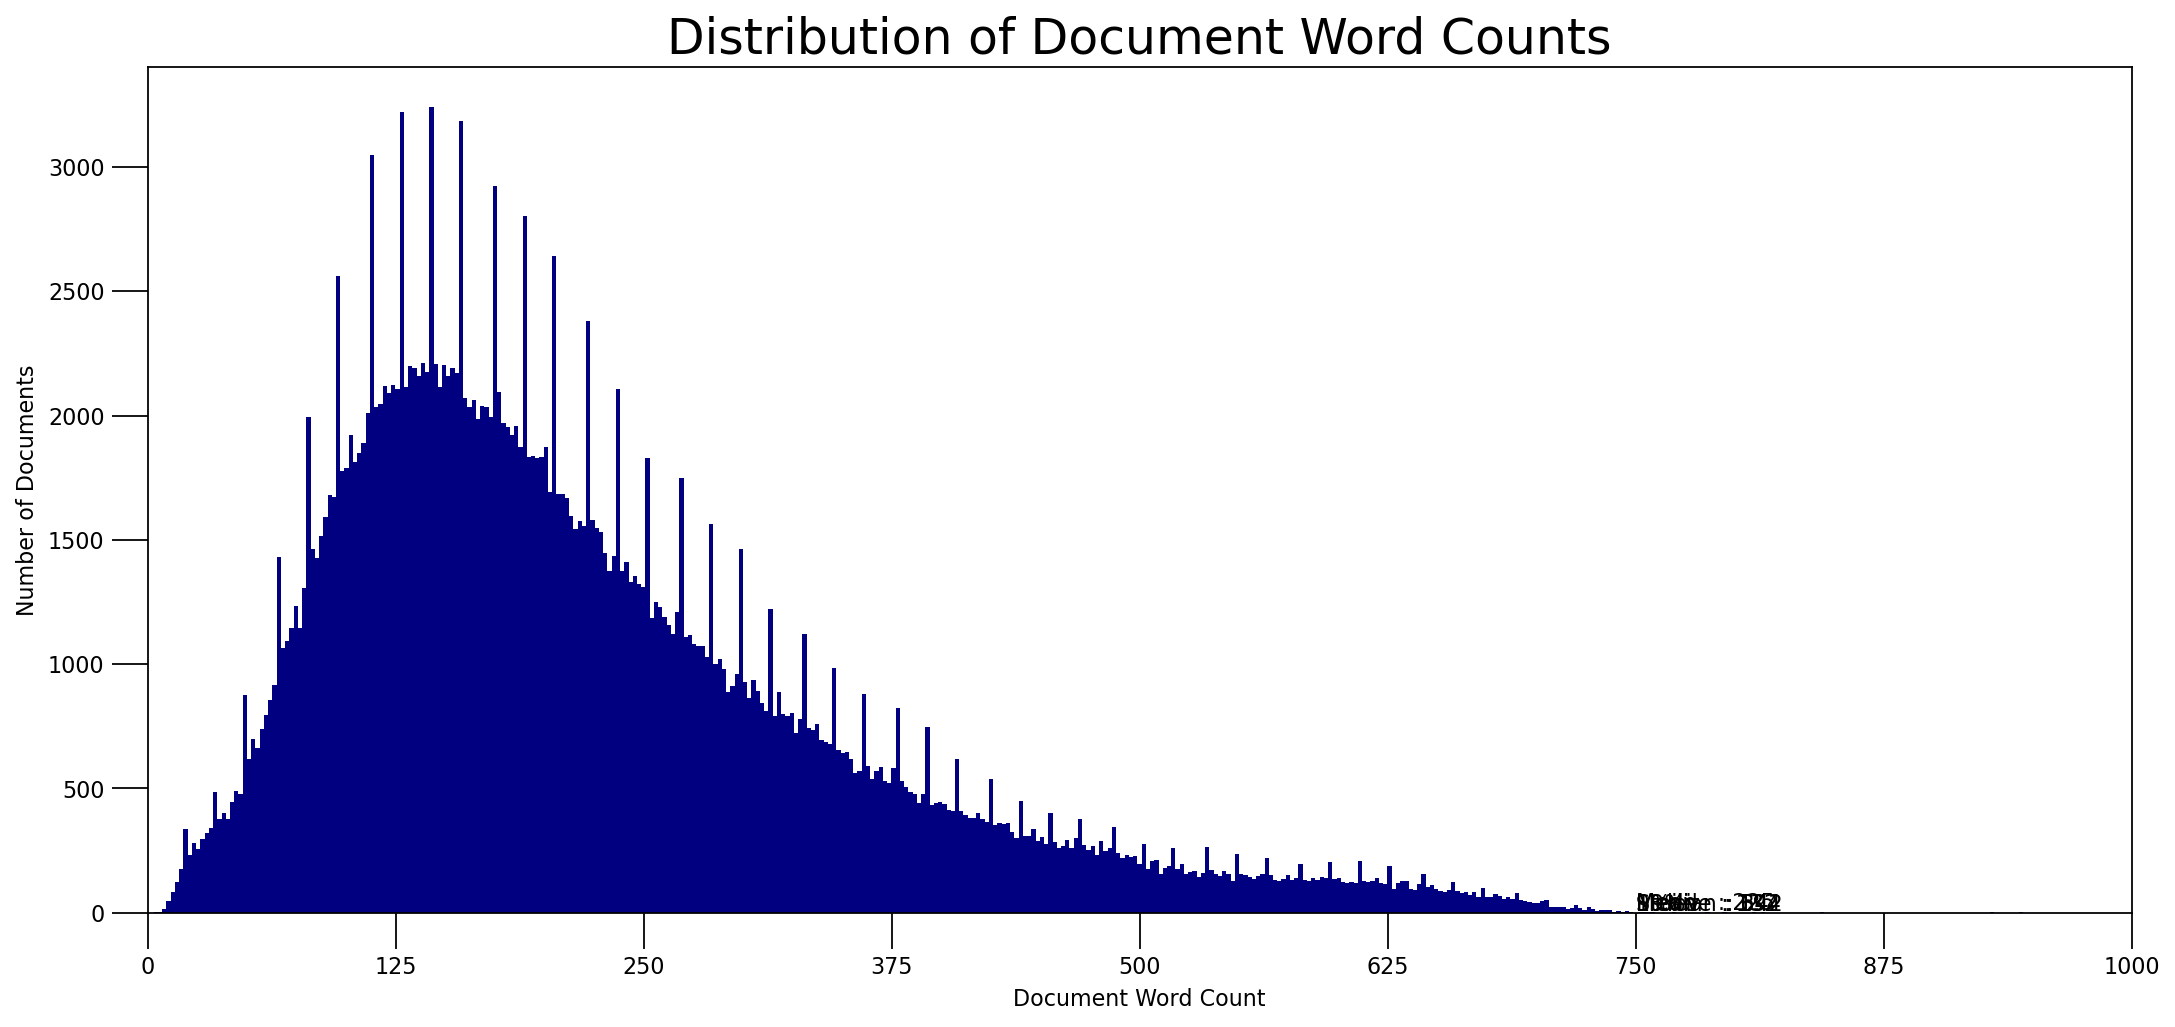

In [17]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 10, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  9, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  8, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  7, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  6, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

наиболее часто количество слов в рецензии ~125-130

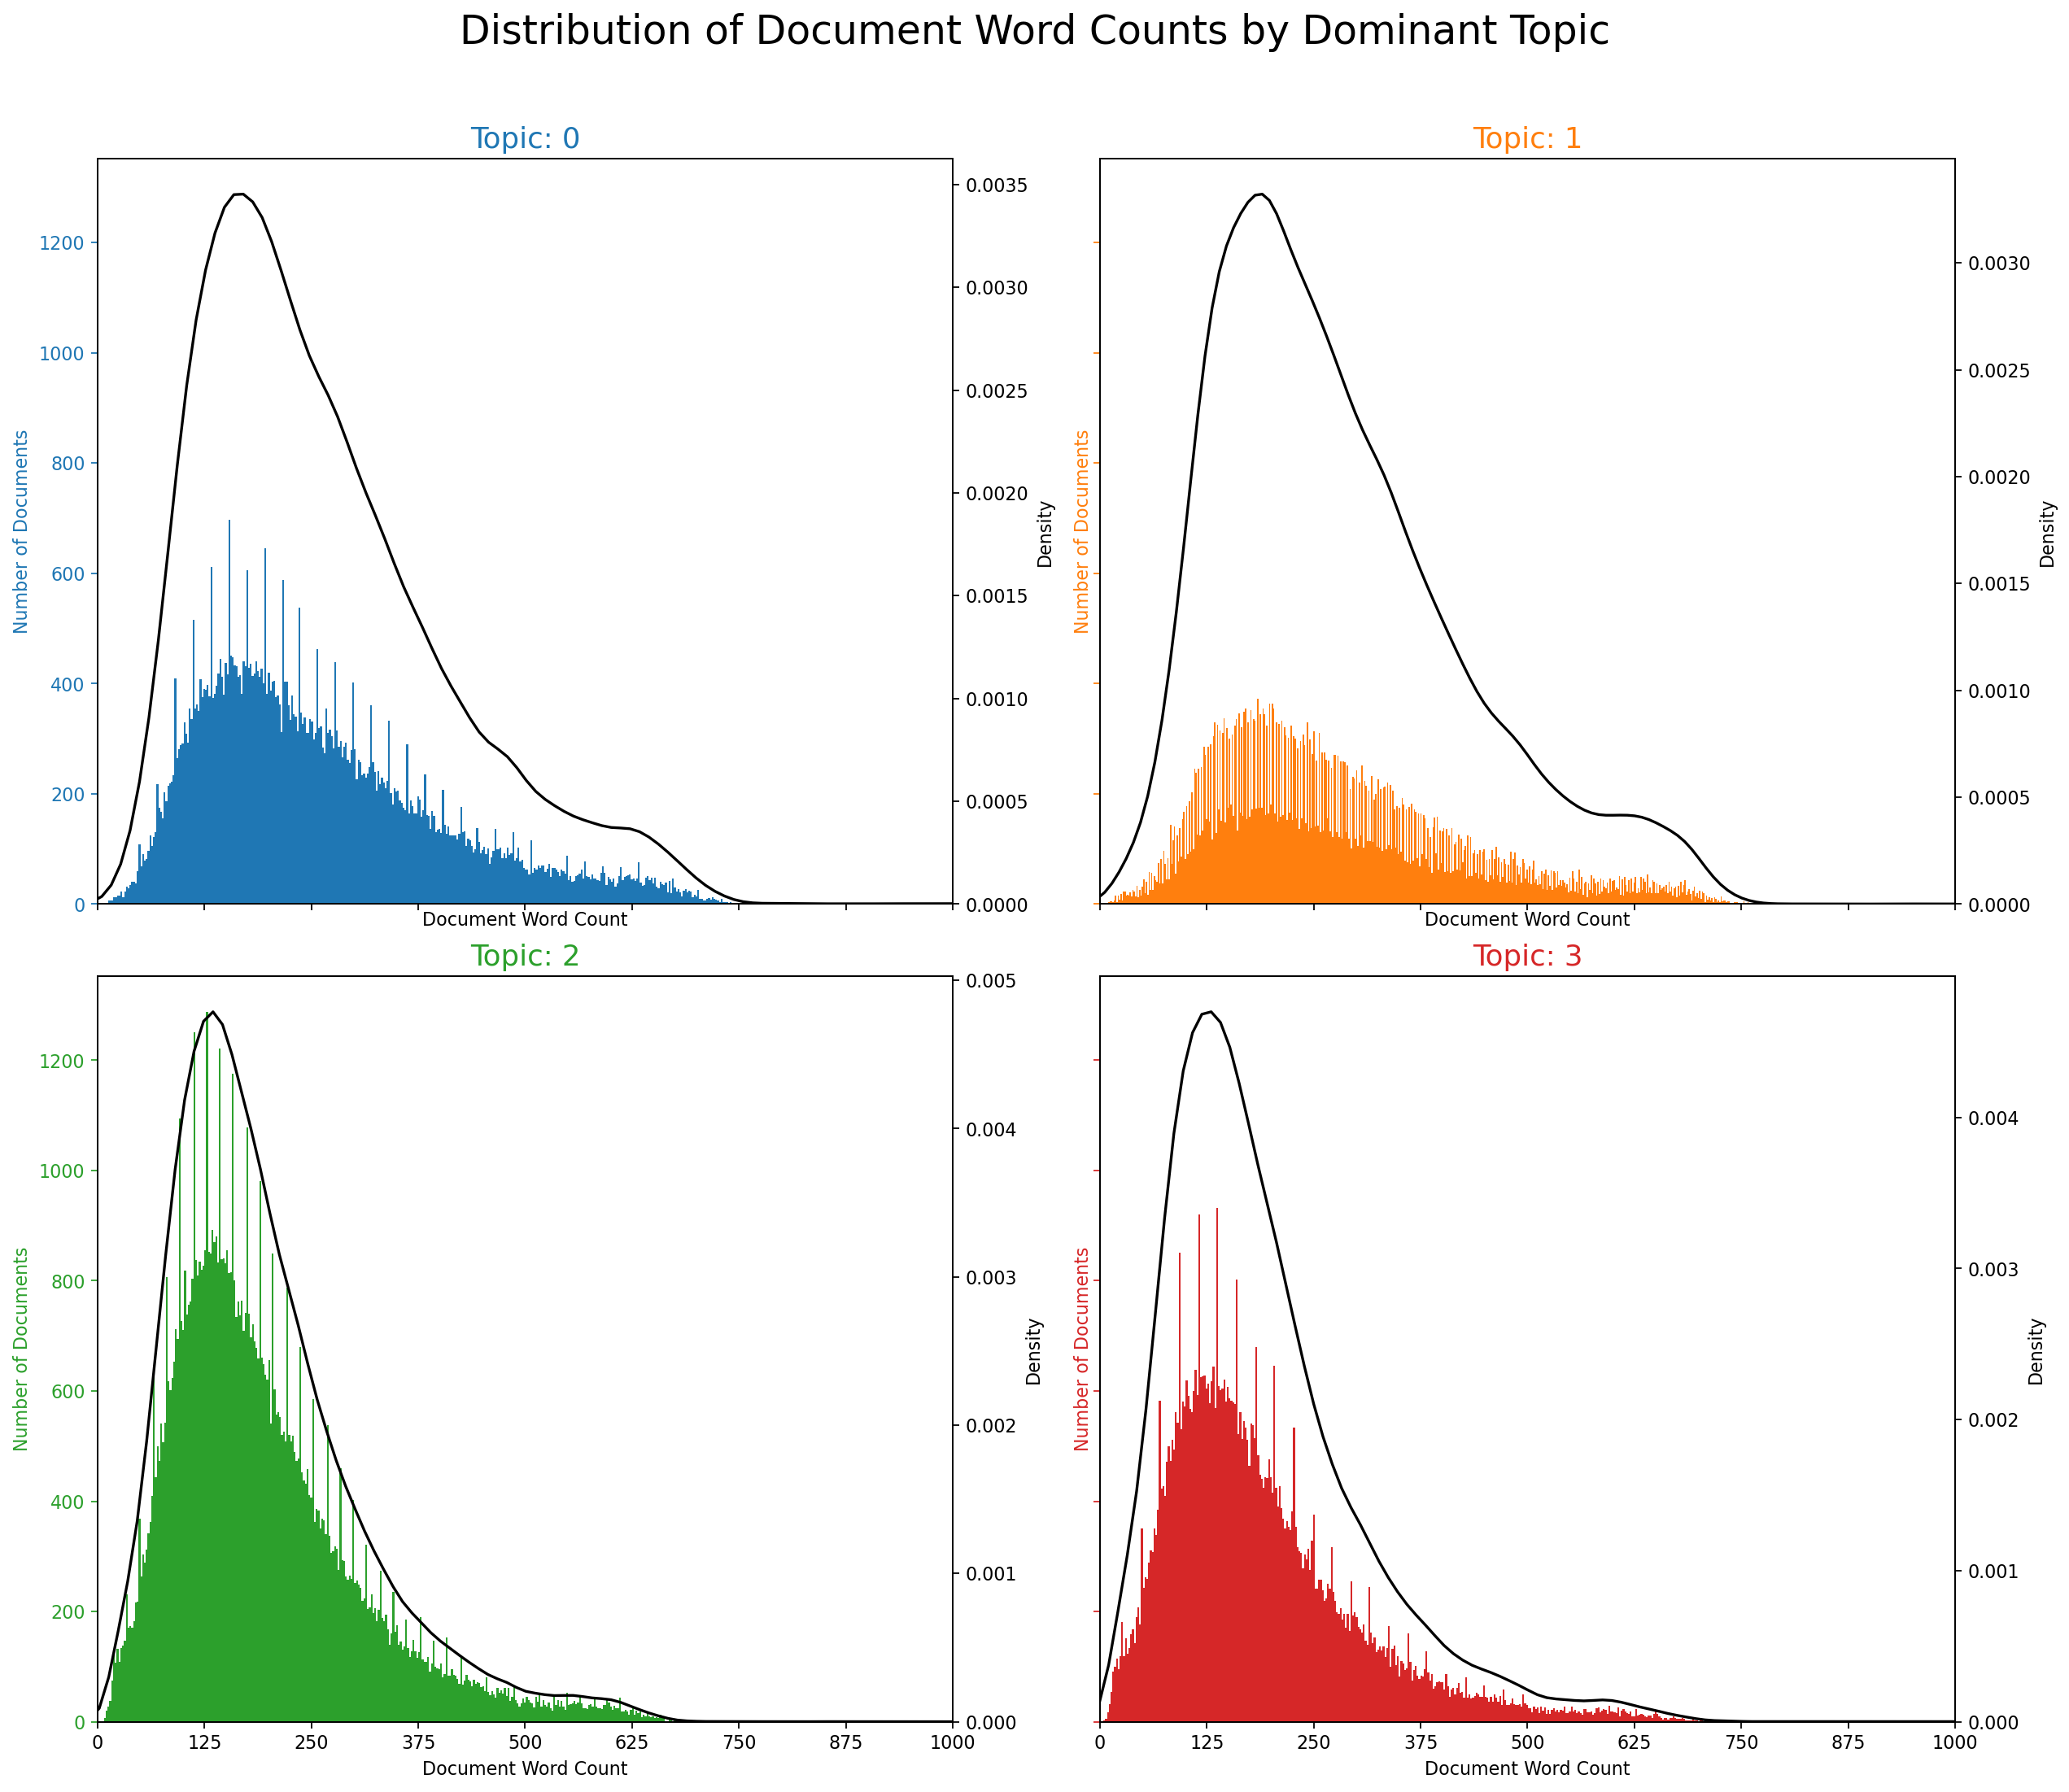

In [18]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

такое же распределение можно построить и по темам.

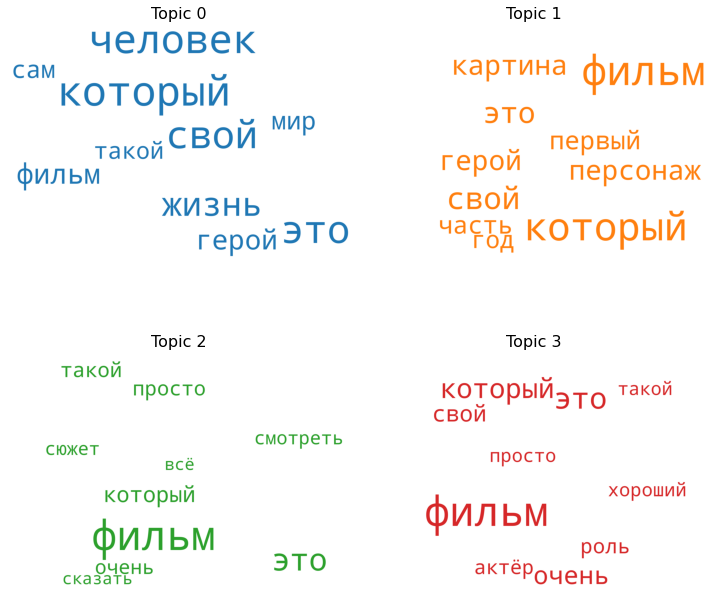

In [19]:
# 1. Wordcloud of Top N words in each topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

также построим облако слов по темам.

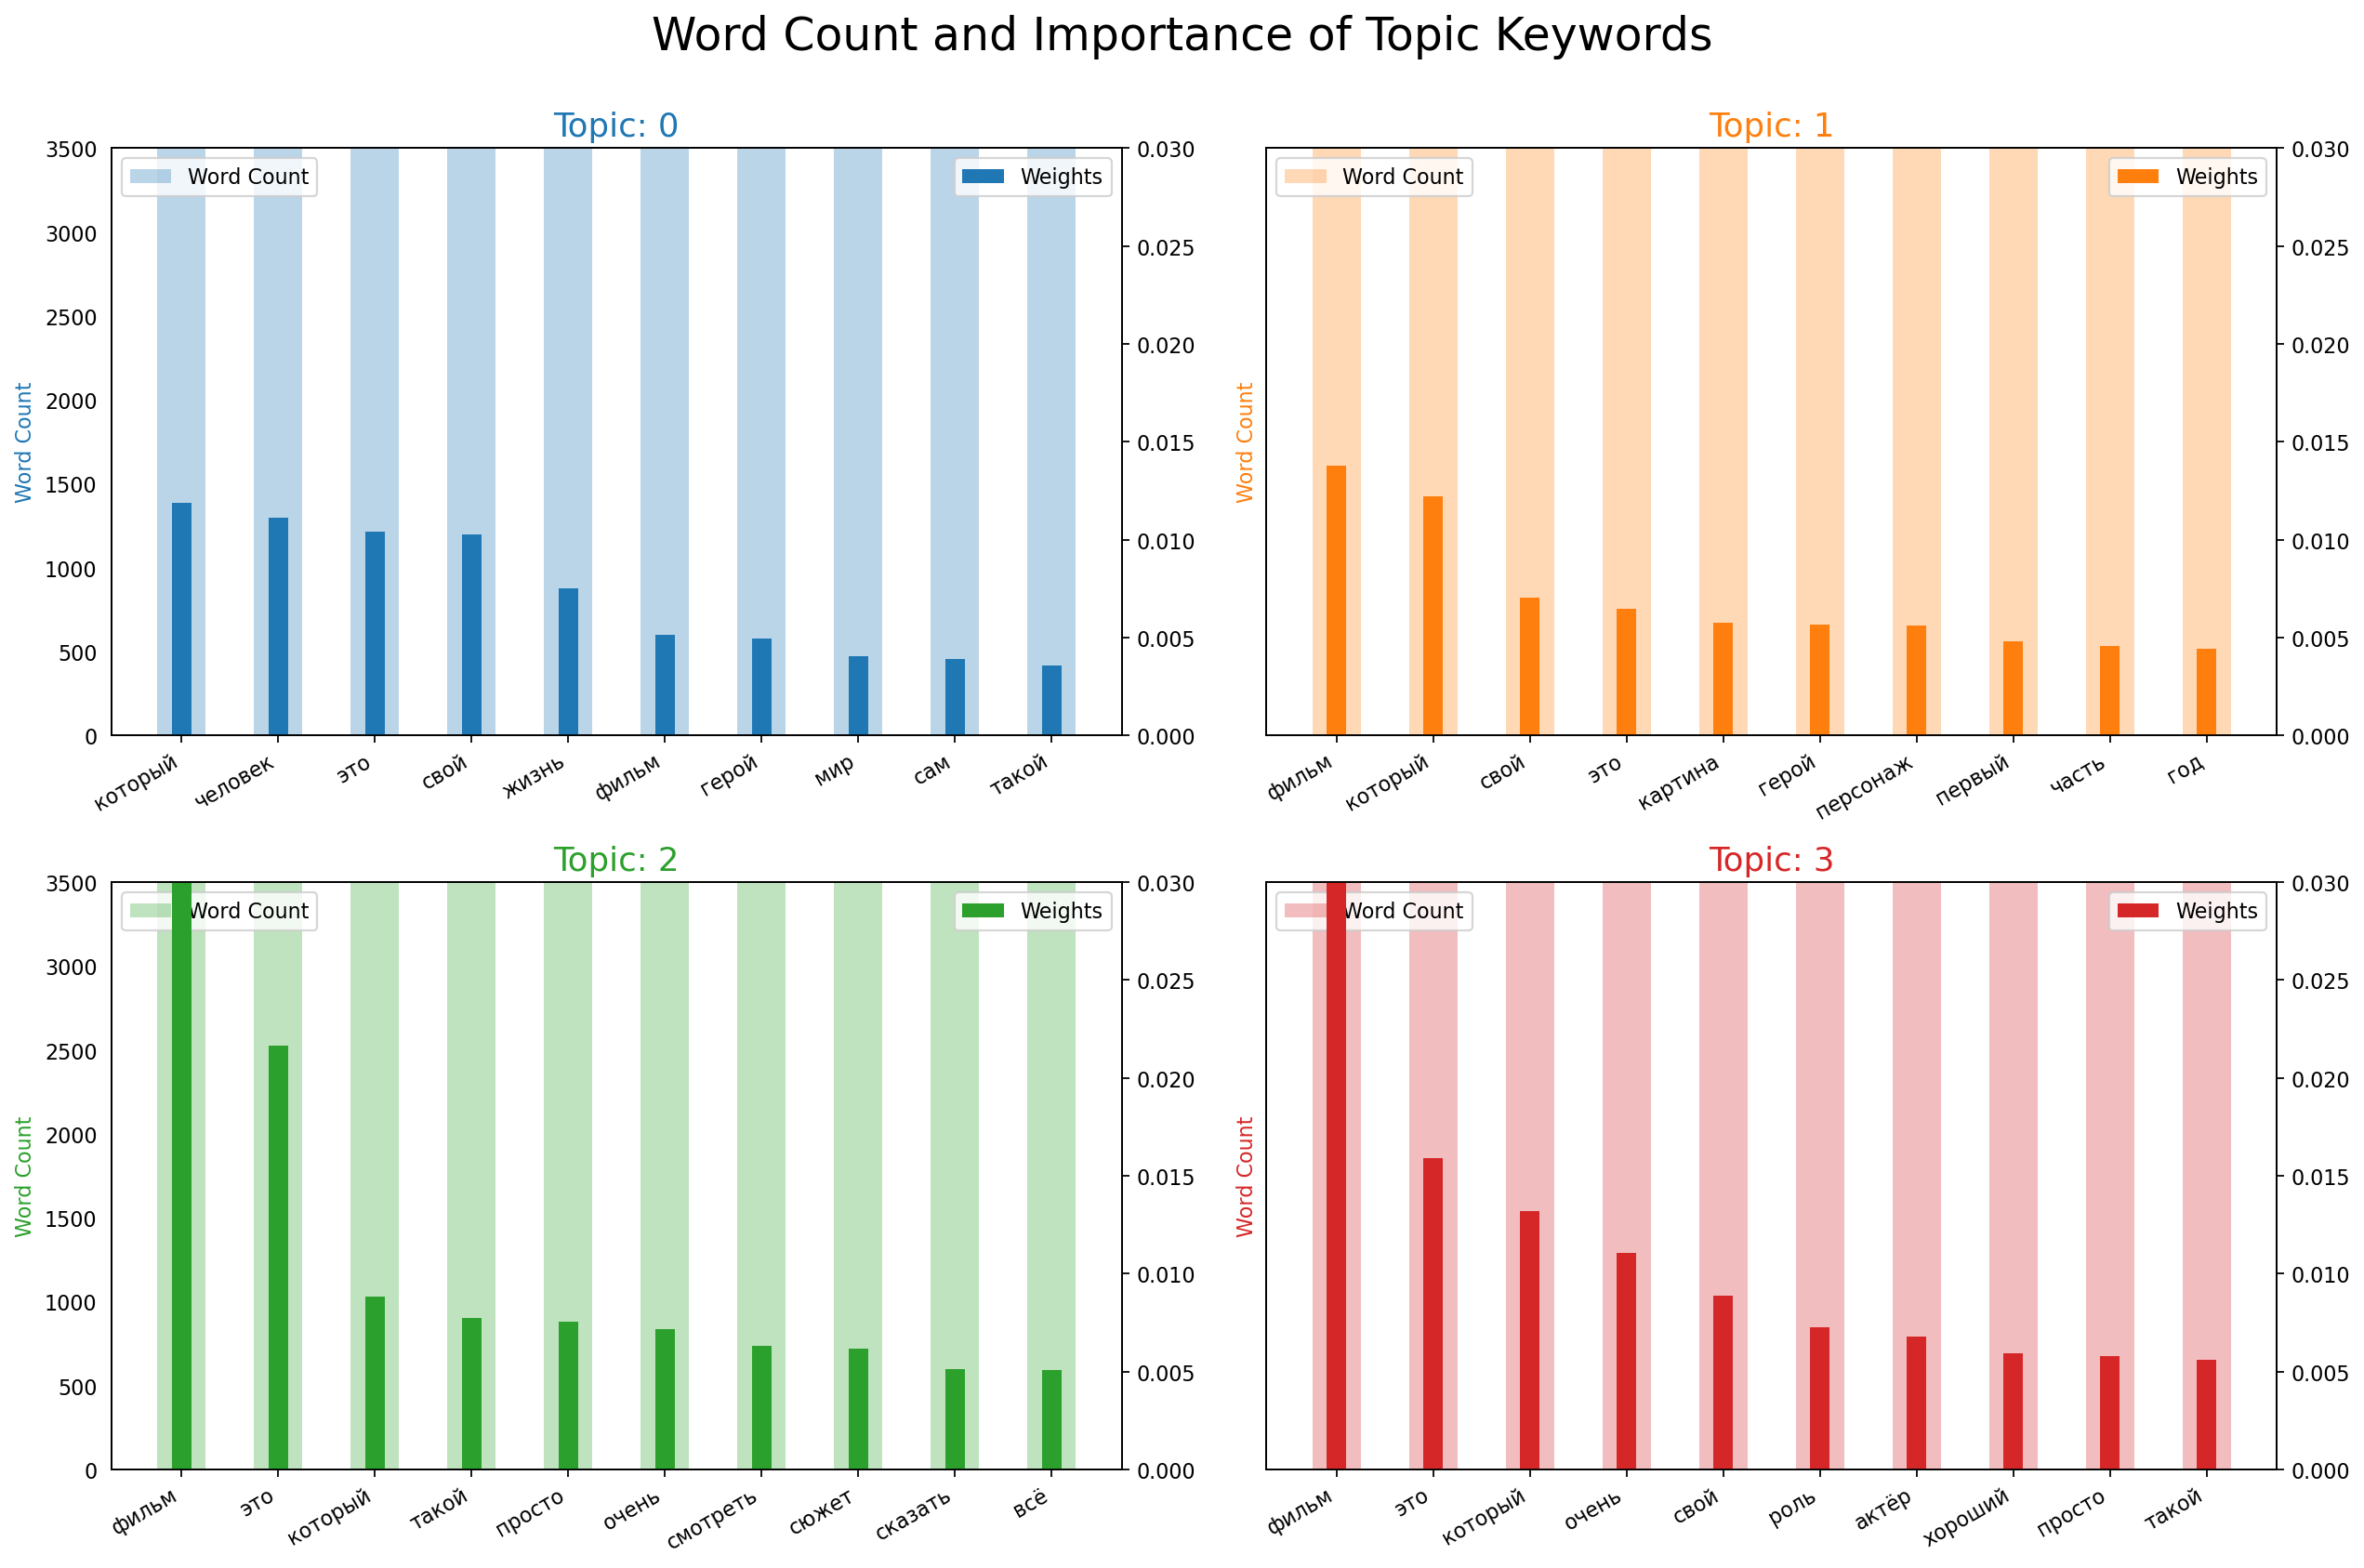

In [20]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts1 for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

также можно посмотреть как часто ключевые слова встречаются в темах и их вес.

In [26]:
# # Sentence Coloring of N Sentences
# def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
#     corp = corpus[start:end]
#     mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

#     fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
#     axes[0].axis('off')
#     for i, ax in enumerate(axes):
#         if i > 0:
#             corp_cur = corp[i-1] 
#             topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
#             word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
#             ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
#                     fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

#             # Draw Rectange
#             topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
#             ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
#                                    color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

#             word_pos = 0.06
#             for j, (word, topics) in enumerate(word_dominanttopic):
#                 if j < 14:
#                     ax.text(word_pos, 0.5, word,
#                             horizontalalignment='left',
#                             verticalalignment='center',
#                             fontsize=16, color=mycolors[topics],
#                             transform=ax.transAxes, fontweight=700)
#                     word_pos += .009 * len(word)  # to move the word for the next iter
#                     ax.axis('off')
#             ax.text(word_pos, 0.5, '. . .',
#                     horizontalalignment='left',
#                     verticalalignment='center',
#                     fontsize=16, color='black',
#                     transform=ax.transAxes)       

#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
#     plt.tight_layout()
#     plt.show()

# sentences_chart() 

In [22]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

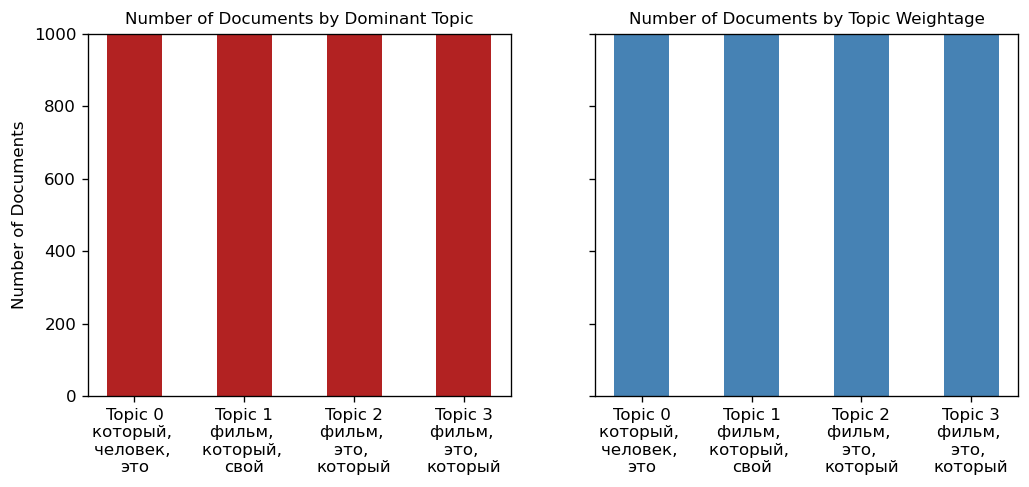

In [23]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [24]:
# Get topic weights and dominant topics ------------
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 259042 samples in 4.951s...
[t-SNE] Computed neighbors for 259042 samples in 17.788s...
[t-SNE] Computed conditional probabilities for sample 1000 / 259042
[t-SNE] Computed conditional probabilities for sample 2000 / 259042
[t-SNE] Computed conditional probabilities for sample 3000 / 259042
[t-SNE] Computed conditional probabilities for sample 4000 / 259042
[t-SNE] Computed conditional probabilities for sample 5000 / 259042
[t-SNE] Computed conditional probabilities for sample 6000 / 259042
[t-SNE] Computed conditional probabilities for sample 7000 / 259042
[t-SNE] Computed conditional probabilities for sample 8000 / 259042
[t-SNE] Computed conditional probabilities for sample 9000 / 259042
[t-SNE] Computed conditional probabilities for sample 10000 / 259042
[t-SNE] Computed conditional probabilities for sample 11000 / 259042
[t-SNE] Computed conditional probabilities for sample 12000 / 259042
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 122000 / 259042
[t-SNE] Computed conditional probabilities for sample 123000 / 259042
[t-SNE] Computed conditional probabilities for sample 124000 / 259042
[t-SNE] Computed conditional probabilities for sample 125000 / 259042
[t-SNE] Computed conditional probabilities for sample 126000 / 259042
[t-SNE] Computed conditional probabilities for sample 127000 / 259042
[t-SNE] Computed conditional probabilities for sample 128000 / 259042
[t-SNE] Computed conditional probabilities for sample 129000 / 259042
[t-SNE] Computed conditional probabilities for sample 130000 / 259042
[t-SNE] Computed conditional probabilities for sample 131000 / 259042
[t-SNE] Computed conditional probabilities for sample 132000 / 259042
[t-SNE] Computed conditional probabilities for sample 133000 / 259042
[t-SNE] Computed conditional probabilities for sample 134000 / 259042
[t-SNE] Computed conditional probabilities for sample 135000 / 259042
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 241000 / 259042
[t-SNE] Computed conditional probabilities for sample 242000 / 259042
[t-SNE] Computed conditional probabilities for sample 243000 / 259042
[t-SNE] Computed conditional probabilities for sample 244000 / 259042
[t-SNE] Computed conditional probabilities for sample 245000 / 259042
[t-SNE] Computed conditional probabilities for sample 246000 / 259042
[t-SNE] Computed conditional probabilities for sample 247000 / 259042
[t-SNE] Computed conditional probabilities for sample 248000 / 259042
[t-SNE] Computed conditional probabilities for sample 249000 / 259042
[t-SNE] Computed conditional probabilities for sample 250000 / 259042
[t-SNE] Computed conditional probabilities for sample 251000 / 259042
[t-SNE] Computed conditional probabilities for sample 252000 / 259042
[t-SNE] Computed conditional probabilities for sample 253000 / 259042
[t-SNE] Computed conditional probabilities for sample 254000 / 259042
[t-SNE] Computed con

Loading BokehJS ...

In [25]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.102244  0.011935       1        1  28.212641
0      0.138958  0.058468       2        1  26.971362
1      0.026544 -0.126478       3        1  23.112124
3     -0.063258  0.056074       4        1  21.703873, topic_info=         Term          Freq         Total Category  logprob  loglift
166     фильм  1.443435e+06  1.443435e+06  Default  30.0000  30.0000
255     очень  2.989470e+05  2.989470e+05  Default  29.0000  29.0000
47      жизнь  1.837360e+05  1.837360e+05  Default  28.0000  28.0000
275      роль  1.596650e+05  1.596650e+05  Default  27.0000  27.0000
144  смотреть  1.714670e+05  1.714670e+05  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
19      время  5.046198e+04  2.075614e+05   Topic4  -5.5470   0.1135
11       весь  5.100409e+04  2.204852e+05   Topic4  -5.5363   0.0638
170   человек  5.389274e+04  3.172143e+05   Topic4  -5.4812  -0.2449
276       сам  4.735626e+04  2.038954e+05   Topic4  -5.6105   0.0678
157     сюжет  4.645775e+04  2.034546e+05   Topic4  -5.6297   0.0508

[407 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7626      3  0.999776        dc
7628      3  0.999815    marvel
9669      1  0.999597     аанга
6583      3  0.999895     агент
2998      1  0.169611   актриса
...     ...       ...       ...
176       1  0.092890  являться
176       2  0.262292  являться
176       3  0.425405  являться
176       4  0.219411  являться
6582      1  0.998740       яга

[745 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])